In [1]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import sys
import os
import access_era_5 as access_era_5
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
sys.path.append(os.path.abspath(".."))

from utils.lstmModel import LstmModel
import utils.lstm as lstm
from utils.logger import Logger

logger = Logger.configurar_logger(nome_arquivo="lstmEra5.log", nome_classe="Lstm Era5")
logger.info("Iniciando a execução do script Lstm com dataset Era 5.")

2025-09-30 20:38:10,549 - Lstm Era5 - INFO - Iniciando a execução do script Lstm com dataset Era 5.


/home/pbose/tcc/pesquisa/era5/access_era_5.py:11: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(caminho_completo, chunks={"valid_time": 100})


<xarray.DataArray 'tp' (valid_time: 728, latitude: 721, longitude: 1440)> Size: 3GB
dask.array<open_dataset-tp, shape=(728, 721, 1440), dtype=float32, chunksize=(100, 121, 240), chunktype=numpy.ndarray>
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2024-01-01 ... 2024-12-31T22:...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 12kB dask.array<chunksize=(100,), meta=np.ndarray>
Attributes: (12/32)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_totalNumber:                         0
    GR

2025-09-30 20:38:13,025 - Lstm Era5 - INFO - Dados carregados com sucesso. Total de 91 registros.


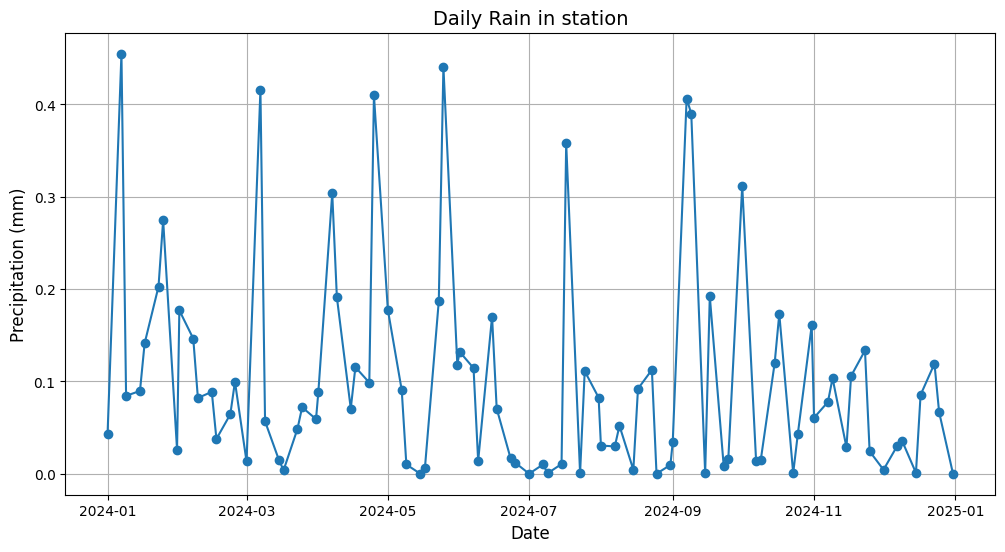

In [ ]:
timeseries = access_era_5.recuperar_dados_era_5(groupDay=True)
logger.info(f"Dados carregados com sucesso. Total de {len(timeseries)} registros.")
dias = timeseries['valid_time']

total_chuva = timeseries['tp']
dias = pd.to_datetime(dias)

# Faz o plot
plt.figure(figsize=(12,6))
plt.plot(dias, total_chuva, marker="o", linestyle="-")

plt.title("Daily Rain in station", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Precipitation (mm)", fontsize=12)
plt.grid(True)
plt.show()


In [ ]:
lookback = 15
logger.info(f"Preparando sequências com um lookback de {lookback} dias.")
X, y = lstm.create_sequences_pytorch(total_chuva, lookback=lookback)
train_size = int(len(timeseries) * 0.68)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


dates_aligned = dias[lookback:]
train_date, test_date = dates_aligned[:train_size] , dates_aligned[train_size:]
logger.info(f"Sequências criadas. Treino: {len(X_train)} amostras, Teste: {len(X_test)} amostras.")


In [ ]:
n_epochs = 50
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
model = LstmModel(input_dim=1, hidden_dim=256, layer_dim=4, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
logger.info(f"Iniciando treinamento do modelo por {n_epochs} épocas com batch_size de {batch_size}.")

# --- Loop de Treinamento ---
# Este loop agora foca APENAS em treinar o modelo
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad() # zera os gradientes
        y_pred, _ = model(Xb)             # faz forward
        loss = criterion(y_pred, yb) # calcula erro (MSE)
        loss.backward()  # backpropagation (calcula gradientes)
        optimizer.step()  # ajusta os pesos do modelo
        epoch_loss += loss.item() * Xb.size(0)

# --- Bloco de Avaliação Final (executado apenas uma vez) ---
logger.info("Treinamento finalizado.")
model.eval()  # modo avaliação
with torch.no_grad():
    # Previsões no conjunto de teste
    X_test_device = X_test.to(device)
    y_pred_test, _ = model(X_test_device)   
    # Se for LSTM com saída 2D (batch, 1), transforma para 1D
    y_pred_np = y_pred_test.cpu().numpy().flatten()
    y_test_np = y_test.cpu().numpy().flatten()
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    
    # MSE
    mse = mean_squared_error(y_test_np, y_pred_np)
    
    # MAE
    mae = mean_absolute_error(y_test_np, y_pred_np)
    
logger.info(f"Avaliação do Modelo - RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")



# --- Novo Bloco para Imprimir Previsto vs. Esperado ---
logger.info("\n--- Comparando Valores Previstos vs. Esperados (10 primeiros exemplos do teste) ---")
model.eval()
with torch.no_grad():
    # Pega as previsões finais do conjunto de teste
    X_test_device = X_test.to(device)
    y_pred_test, _ = model(X_test_device)   
    # Se for LSTM com saída 2D (batch, 1), transforma para 1D
    y_pred_np = y_pred_test.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    # Itera sobre os 10 primeiros exemplos e imprime lado a lado
    for i in range(10):
        previsto = y_pred_np[i][0]
        esperado = y_test_np[i][0]
        logger.info(f"Exemplo {i+1}: Previsto = {previsto}, Esperado = {esperado}")

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_date, y_test_np, label="Real (Dados de Teste)")
plt.plot(test_date, y_pred_np, label="Previsto (LSTM)")
plt.title("Previsão LSTM - Parte de Teste")
plt.xlabel("Data")
plt.ylabel("Valor de Chuva")
plt.legend()
plt.show()
logger.info("Execução do script LSTM com ERA 5 finalizada.")
logger.info("\n\n\n\n\n")